In [1]:
import numpy as np
import pandas as pd 
import re
import os
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/glove6b100d-2/glove.6B.100d.txt


In [3]:
train_csv = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_csv = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission_csv = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
train_csv.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df = train_csv
train_df = train_df.drop('location', axis = 1)
train_df.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#re.findall(r'[\w\.-]+@[\w\.-]+', tweet) ----> email
def remove_hashtag(tweet) :
    hash_part = re.findall(r'#(\w+)',tweet)
    for index,words in enumerate(hash_part) :
        sub = re.findall(r'[A-Z][A-Z0-9]+', words)
        if sub :
            split_word = words.split(sub[0])
            string = sub[0] + " " + split_word[1]
            if split_word[1] :
                tweet = re.sub(r'#'+sub[0]+'[a-z]+',string,tweet)
            else :
                tweet = re.sub(r'#'+sub[0],string,tweet)
        elif re.findall(r'[A-Z][a-z]+',words) :
            sub = re.findall(r'[A-Z][a-z]+',words)
            string = ""
            if len(sub) !=1 :
                for sub_word in sub :
                    string = string + " "  + sub_word
                tweet = re.sub(r'#'+sub[0]+'[a-zA-Z]+', string, tweet)
            else :
                string = string + sub[0] + " "
                tweet = re.sub(r'#'+sub[0], string, tweet)
        else :
            tweet = re.sub(r'#'+hash_part[index], hash_part[index], tweet)
    return tweet

def rewrite_single_qoute(tweet) :
    tweet = re.sub(r'i\'m', 'i am', tweet)
    tweet = re.sub(r'I\'m', 'i am', tweet)
    tweet = re.sub(r'can\'t', 'can not', tweet)
    tweet = re.sub(r'omg|Omg', 'oh my god', tweet)
    #tweet = re.sub(r'', '', tweet)
    tweet = re.sub(r'(\w+)\'re', '\g<1>are', tweet)
    tweet = re.sub(r'(\w+)\'s', '\g<1>is', tweet)
    tweet = re.sub(r'dammit', 'damn it', tweet)
    tweet = re.sub(r'won\'t', 'will not', tweet)
    tweet = re.sub(r'wont', 'will not', tweet)
    tweet = re.sub(r'(\w+)\'d', '\g<1>would', tweet)
    return tweet

def remove_additional(tweet) :
    tweet = re.sub('[^a-zA-z]+',' ',tweet)
    return tweet


def data_preprocessing(tweet) :
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@(\w*)', '', tweet)
    tweet = remove_hashtag(tweet)
    tweet = re.sub(r'\n',' ', tweet) 
    tweet = re.sub('\s+', ' ', tweet).strip()
    # rewriting words containing single qoute 
    tweet = rewrite_single_qoute(tweet)
    tweet = remove_additional(tweet)#removing additional unwanted characters (and also remaining Hashtags)
    tweet = tweet.lower()
    #stop words code to be written below
    tweet = tweet.split()
    tweet = [w for w in tweet if not w in set(stopwords.words('english'))] 
    tweet = ' '.join(tweet)
    #lemmatization
    token_list = word_tokenize(tweet)
    tweet = ' '.join([lemmatizer.lemmatize(w) for w in token_list])
    return tweet

In [6]:
train_df["keyword"] = train_df["keyword"].fillna(' ')
train_df['joined'] = train_df[['keyword', 'text']].apply(lambda x: ' '.join(x), axis = 1)
train_df.head()

,id,keyword,text,target,joined
0,1,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake...
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' ar...
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation ..."
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska a...


In [7]:
train_df['joined'] = train_df['joined'].apply(lambda x : data_preprocessing(x))
train_df.head()

,id,keyword,text,target,joined
0,1,,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [8]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'themselves', "didn't", 'such', 'mustn', 'him', 'had', 'no', 'over', 'hers', 'your', 'same', 'any', "haven't", 'o', 'because', 'with', 'can', 'd', 'isn', 'am', 'that', "doesn't", 'to', 'of', 'for', 'weren', 'each', "weren't", 'has', 'an', 've', 'below', 'off', 'aren', 'our', 'needn', "you've", 'those', "it's", 'most', 'both', 'are', 'some', 'he', 'up', 'won', 'these', 'again', 'not', 'shouldn', 'll', 'doing', 'into', 'from', 'did', 'how', 'mightn', "shouldn't", 'should', "needn't", 'my', 'does', 't', 'will', 'be', 'when', 'while', 'very', 'out', 'too', 'have', 'as', 'ours', "hasn't", 'if', 'was', 'myself', 'between', 'its', 'than', "mustn't", 'more', 'me', 'haven', 'what', 'himself', 'yourselves', 'ain', 'further', "wouldn't", 'on', 'own', "won't", 'them', 'her', 'only', 'ma', 'then', 'm', 'being', 'above', 'don', 'after', 'they', 'this', "you'll", "couldn't", 's', 'i', 'under', 'and', "that'll", 'before', 'a', "shan't", 'you', "you're", 'during', 'itself', 'at', 'through', 'y', "wasn

In [9]:
tweet_max_length = max(len(x) for x in train_df["joined"])
print(tweet_max_length)

156


In [10]:
def create_corpus_new(df):
    corpus=[]
    for tweet in df['joined'] :
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus  



corpus=create_corpus_new(train_df)

In [11]:
embedding_dict={}
with open('/kaggle/input/glove6b100d-2/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]  # added
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [12]:
#HYPER PARAMETERS
max_length = tweet_max_length
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'

In [13]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

training_tweets, validation_tweets, training_targets, validation_targets = train_test_split(train_df['joined'], train_df['target'], test_size=0.2, random_state=42)
#Sequencing and padding training data
training_sequences = tokenizer.texts_to_sequences(training_tweets)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#Sequencing and padding validation data
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#tweet_sequences = tokenizer.texts_to_sequences(corpus)
#tweets_padded = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in word_index.items() :
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec  


In [14]:
#import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix), input_length=max_length,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64, dropout=0.2, recurrent_dropout = 0.2, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimzer=Adam(lr=3e-4)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

############################################################################
training_tweets, validation_tweets, training_targets, validation_targets = train_test_split(train_df['joined'], train_df['target'], test_size=0.2, random_state=42)

history=model.fit(training_padded,training_targets,batch_size=4,epochs=10,validation_data=(validation_padded,validation_targets),verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 156, 100)          1272600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 156, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 156, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,402,521
Trainable params: 129,921
Non-trainable params: 1,272,600
________________________________________

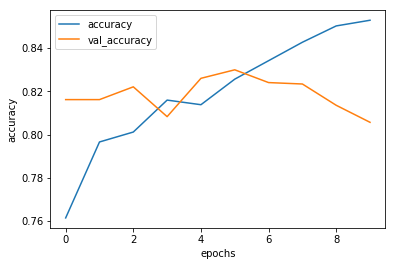

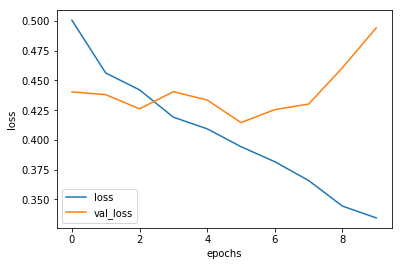

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss', 'val_loss'])
plt.show()

In [16]:
test_csv.head()
sample_submission_csv.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
test_csv["keyword"] = test_csv["keyword"].fillna(' ')
test_csv['joined'] = test_csv[['keyword', 'text']].apply(lambda x: ' '.join(x), axis = 1)
test_csv.head()

,id,keyword,location,text,joined
0,0,,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities,..."
2,3,,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese a..."
3,9,,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [18]:
test_csv['joined'] = test_csv['joined'].apply(lambda x : data_preprocessing(x))
test_csv.head()

,id,keyword,location,text,joined
0,0,,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [19]:
test_sequences = tokenizer.texts_to_sequences(test_csv['joined'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
predictions = model.predict(test_padded)

In [21]:
sample_submission_csv['target'] = (predictions > 0.5).astype(int)

In [22]:
sample_submission_csv.to_csv("submission.csv", index=False, header=True)

In [23]:
#https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel

from IPython.display import HTML
import base64

def create_download_link(df, title = "Download CSV file", filename = "subm.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)



create_download_link(sample_submission_csv)


how u doing